In [3]:
import torch
import torch.nn as nn

# Model

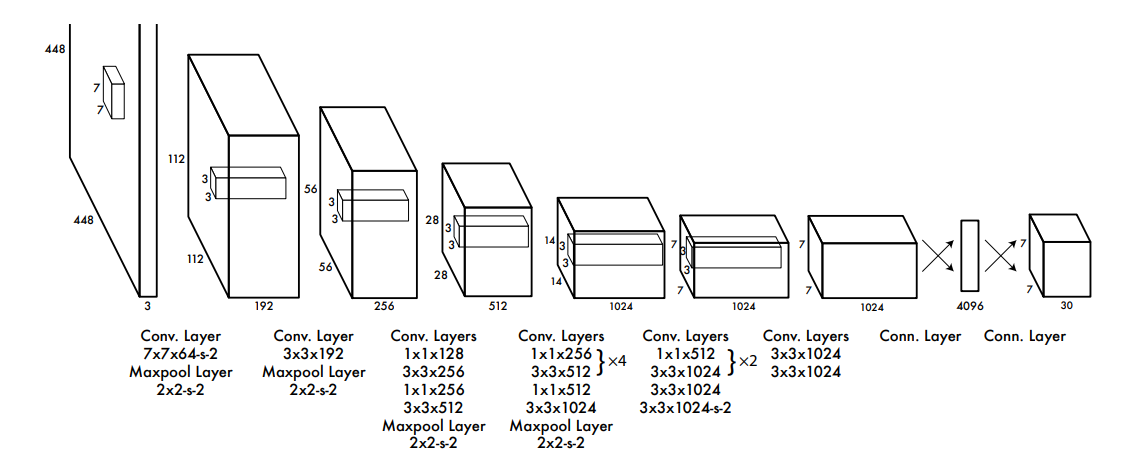
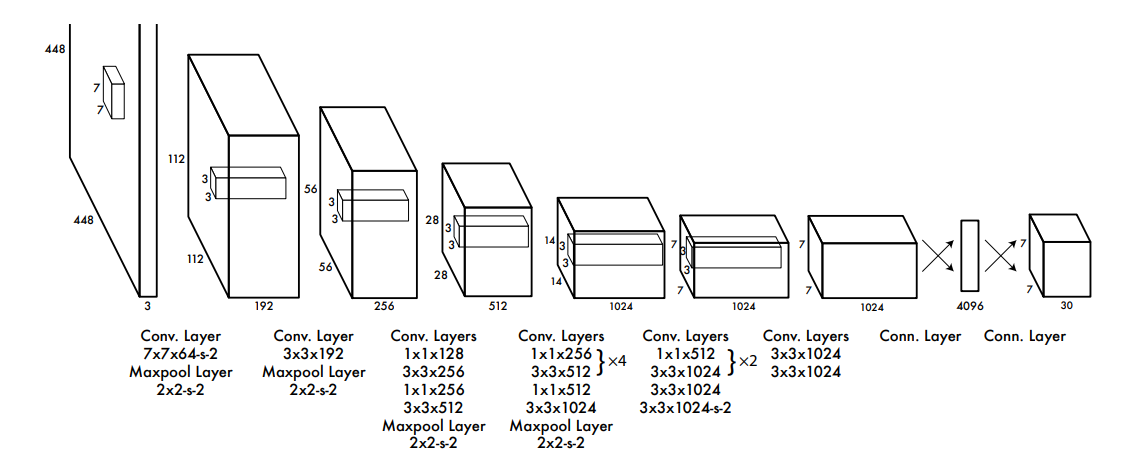

In [4]:
class CNNBlock(nn.Module):
    def __init__(self,in_channels,out_channels, kernel_size = 3, stride = 1, padding = 1):
        super().__init__()
        self.conv2d=nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = stride, padding = padding, bias = False)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leaky_relu(self.batchnorm(self.conv2d(x)))

In [5]:
class YoloV1(nn.Module):
    def __init__(self, grid_size, n_box, n_class, input_channels=3):
        super().__init__()
        self.darknet = nn.Sequential(
            CNNBlock(in_channels = input_channels, out_channels = 64, kernel_size = 7, stride = 2, padding = 2),#1
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            CNNBlock(in_channels = 64, out_channels = 192, kernel_size = 3, stride = 2, padding = 1),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            CNNBlock(in_channels = 192, out_channels = 128, kernel_size = 1, stride = 1, padding = 0),
            CNNBlock(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
            CNNBlock(in_channels = 256, out_channels = 256, kernel_size = 1, stride = 1, padding = 0),
            CNNBlock(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            CNNBlock(in_channels = 512, out_channels = 256, kernel_size = 1, stride = 1, padding = 0),
            CNNBlock(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
            CNNBlock(in_channels = 512, out_channels = 256, kernel_size = 1, stride = 1, padding = 0),
            CNNBlock(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
            CNNBlock(in_channels = 512, out_channels = 256, kernel_size = 1, stride = 1, padding = 0),
            CNNBlock(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
            CNNBlock(in_channels = 512, out_channels = 256, kernel_size = 1, stride = 1, padding = 0),
            CNNBlock(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
            CNNBlock(in_channels = 512, out_channels = 512, kernel_size = 1, stride = 1, padding = 0),
            CNNBlock(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size=2,stride=2),

            CNNBlock(in_channels = 1024, out_channels = 512, kernel_size = 1, stride = 1, padding = 0),
            CNNBlock(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 1, padding = 1),
            CNNBlock(in_channels = 1024, out_channels = 512, kernel_size = 1, stride = 1, padding = 0),
            CNNBlock(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 1, padding = 1),
            CNNBlock(in_channels = 1024, out_channels = 1024, kernel_size = 3, stride = 1, padding = 1),
            CNNBlock(in_channels = 1024, out_channels = 1024, kernel_size = 3, stride = 2, padding = 2),

            CNNBlock(in_channels = 1024, out_channels = 1024, kernel_size = 3, stride = 1, padding = 2),
            CNNBlock(in_channels = 1024, out_channels = 1024, kernel_size = 3, stride = 1, padding = 1),
            )
        
        self.fc=nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024*grid_size*grid_size,4096),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, grid_size*grid_size*(n_class + n_box*5))
        )

    def forward(self, x):
        x=self.darknet(x)
        return self.fc(x) 

In [6]:
grid_size=7
n_class=20
n_box=2
no_examples=2
points_per_box=4
model = YoloV1(grid_size,n_box,n_class)
x = torch.randn((no_examples, 3, 448, 448))
assert list(model(x).shape)==[no_examples,grid_size*grid_size*(n_class+(points_per_box+1)*n_box)]

# Loss Function

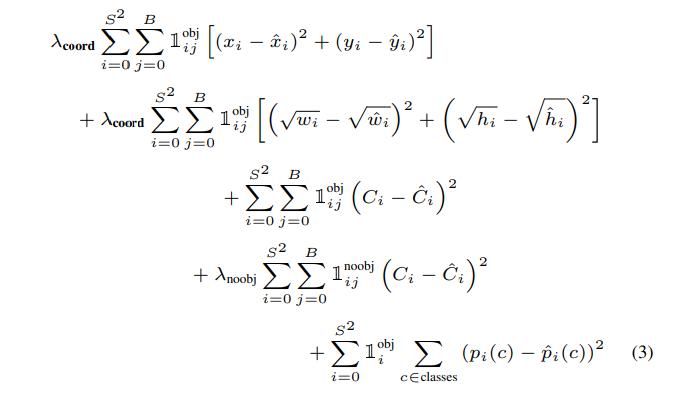
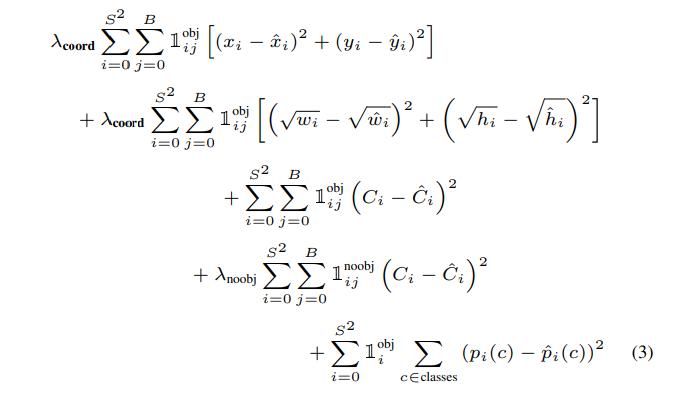

In [7]:
class LossFunction(nn.Module):
    def __init__(self, gris_size = 7, n_box = 2, n_class = 20, lambda_coord = 5, lambda_noobj = 0.5):
        super().__init__()
        self.mse = nn.MSELoss(reduction = 'sum')
        self.lambda_noobj = lambda_noobj
        self.lambda_coord = lambda_coord
        self.n_box = n_box
        self.nclass = 20
        self.n_grid = grid_size

    def forward(self, preds, target):
        """
         
            C: Confidience that there is an object
            X , Y , W , H: (X , Y) midpoints of an object and (W, H) is the width and the height 
            cn: object Class n lower c means class probability. 
         
         
            1 grid prediction [C1 X1 Y1 W1 H1 C2 X2 Y2 W2 H2 c1 c2 c3 ... c(n_class)] we constrain the grids so that each grid can only contain 1 object
            1 grid Target [C X Y W H c1 c2 c3 ... c(n_class)]
            Target.shape = [N , S , S , (5 + c)]
            preds.shape =  [N, S , S ,(c + 5*B)]
        """    



        predictions = preds.reshape(-1, self.n_grid, self.n_grid, (5 * self.n_box + self.n_class) ) # [1,1470] -> [N, S, S, (C + B*5)]

        iou1 = IOU(predictions[..., 1:5], target[..., 1:5])
        iou2 = IOU(predictions[..., 6:10], target[..., 1:5])

        ious = torch.cat([iou1.unsqueeze(0), iou2.unsqueeze(0)], dim=0) # [2, N, S, S]

        iou_maxes, bestbox = torch.max(ious, dim=0) # bestbox  = [0 1 0 0 1 1 1 0 0 ... 0 0 1 0 ...] shape is [N , S , S , 1] each index represents which bounding box to choose

        exists_box = target[..., 0].unsqueeze(3) # dummy dimension [N, S, S, 1]
        
        box_predictions = exists_box * (
            bestbox * predictions[..., 6:10]
            + (1 - bestbox) * predicitions[..., 1:5]
        )

        box_target = exists_box * target[..., 1:5]


        box_preds = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(torch.abs(box_predictions[..., 2:4] + 1e-6))
        box_target = box_target[..., 2:4]* torch.sqrt(box_target[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_preds, end_dim = -2),
            torch.flatten(box_target, end_dim = -2)
        )
        

        obj_box_conf = exists_box * (
            best_box * predictions[..., 5:6] + (1-bestbox) * predictions[..., 0:1]
        )
        object_loss = self.mse(
            torch.flatten(obj_box_conf, end_dim=-2),
            torch.flatten(exists_box * target[..., 0:1], end_dim=-2)
        )


        bbox_j = (1-exists_box) * (
            best_box * predictions[..., 4:5] + (1-bestbox) * predictions[..., 0:1]
        )
        no_obj_loss = self.mse(
            torch.flatten(bbox_j, end_dim=-2),
            torch.flatten((1- exists_box) * target[..., 0:1], end_dim=-2)
        )


        class_loss = self.mse(
            torch.flatten(exists_box* predictions[..., 10:], end_dim=-2),
            torch.flatten(exists_box * target[..., 5:], end_dim=-2)
        )

        loss = (
            self.lambda_coord * box_loss +
            object_loss +
            self.lambda_noobj * no_object_loss +
            class_loss
        )

        return loss

In [8]:
def IOU(boxes_preds, boxes_labels, box_format="midpoint"):
    pass